<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Check for all installs and versions

In [ ]:
!conda list | findstr "pytorch"

pytorch                   2.0.1           py3.11_cuda11.8_cudnn8_0    pytorch
pytorch-cuda              11.8                 h24eeafa_5    pytorch
pytorch-ignite            0.4.12                   pypi_0    pypi
pytorch-lightning         2.0.5                    pypi_0    pypi
pytorch-mutex             1.0                        cuda    pytorch


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip list | findstr "fastai"

fastai                   2.7.12


In [ ]:
!pip list | findstr "duckduckgo"

duckduckgo-search        3.8.3


In [ ]:
!pip list | findstr "fastbook"

fastbook                 0.0.29


In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

## Generate Data Images

In [ ]:
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
urls = search_images('bird photos', max_images=1)
urls[0]

...and then download a URL and take a look at it:

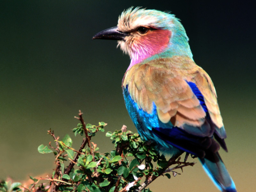

In [ ]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

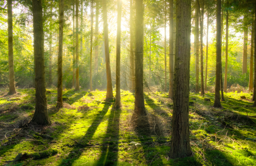

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

## Training the model

```sh
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)
```

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 
    
To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).